<a href="https://colab.research.google.com/github/ariesslin/ie7500-g1-tweet-sentiment-nlp/blob/main/scripts/3.%20Model_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>3a. Baseline Model – TF-IDF + Logistic Regression</strong></h2>
  <p style="color:#333333;">TF-IDF vectorization + logistic regression as a benchmark.</p>
</div>


## Baseline Sentiment Classifier: TF-IDF + Logistic Regression

This notebook implements the **baseline model** for our tweet sentiment classification project, using a combination of **TF-IDF vectorization** and **Logistic Regression**.

### Why TF-IDF + Logistic Regression?

- **TF-IDF** transforms raw tweet text into numerical feature vectors by measuring the importance of words relative to the entire corpus.
- **Logistic Regression** is a simple yet effective linear classifier that provides strong performance with fast training time and easy interpretability.

TF-IDF is ideal for linear models but sensitive to document length. To prevent longer tweets from biasing the model, we apply **L2 normalization**, ensuring each tweet contributes equally regardless of length.

### What This Notebook Covers

- Loads preprocessed training and validation data
- Tokenizes and normalizes text using Gensim and TF-IDF
- Tunes hyperparameters using `GridSearchCV`
- Trains a logistic regression model on vectorized tweets
- Evaluates performance on the validation set using accuracy, precision, recall, F1 score, and a confusion matrix
- Saves the trained pipeline for reuse in evaluation

This baseline serves as a reference point for evaluating deeper models like LSTM and BERT, helping us assess whether the added complexity improves sentiment classification.

In [1]:
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

In [2]:
# Import helper functions
sys.path.append("../utils")
from helper import load_clean_train_val_datasets

In [3]:
train_df, val_df = load_clean_train_val_datasets()

In [4]:
train_df.head()

,text,target
0,doesnt know hahahahahaha hi world twitter,4
1,gahh im hungryy shouldve something teadinner s...,0
2,last day,0
3,sunburn forget put sunblock shnatzi,0
4,usermention want go home contact hurt,0


In [5]:
val_df.head()

,text,target
0,lng fn day mah head killin im tire den bih bt ...,0
1,usermention nah manthat fit lmao run mix oh ma...,4
2,usermention kno right thermostat war almost al...,0
3,usermention awww well dont worry youre miss mu...,0
4,use little girls room soo bad soon leave bos c...,0


#### Observation: Dataset Inspection and Language Quality

After loading the dataset, we inspect the first few rows using `head()`. The `text` column contains raw tweets, which often include:

* Informal language and slang (e.g., "lmao", "bt", "nah manthat")
* Typos, abbreviations, and creative spellings
* Phonetic spellings or dialect-specific phrasing
* Hashtags, emojis, or special characters
* Occasionally, non-English or mixed-language content

This is **expected behavior** for the Sentiment140 dataset, which was collected from Twitter and reflects real-world, noisy text data.

While most tweets are in English or English-based internet slang, it's possible that some non-English tweets are present. For now, we retain this noise to maintain the dataset's realism, which helps models generalize to real-world social media inputs.

In [6]:
# next, we extract targets

# Ensure 'target' is int and remap 4 → 1

X_train = train_df['text'].astype(str)
y_train = train_df['target'].astype(int).replace({4: 1})

X_val = val_df['text'].astype(str)
y_val = val_df['target'].astype(int).replace({4: 1})


# Final check
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("X_train shape:", X_train.shape, "| y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "| y_val shape:", y_val.shape)

Train shape: (1119609, 2)
Validation shape: (239917, 2)
X_train shape: (1119609,) | y_train shape: (1119609,)
X_val shape: (239917,) | y_val shape: (239917,)


In [7]:
# Then, we define pipeline combining TF-IDF and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2)
    )),
    ('clf', LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    ))
])

In [8]:
# Then, we define parameter grid for GridSearch
param_grid = {
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__min_df': [1, 5],
    'tfidf__max_df': [0.7, 0.9],
    'clf__C': [0.1, 1, 10],
    'clf__penalty': ['l2'],  # 'l1' requires solver='liblinear'
    'clf__class_weight': [None, 'balanced']
}

# Setup GridSearchCV with 3-fold CV and weighted F1
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='f1_weighted',
    verbose=1,
    n_jobs=-1
)

# Perform grid search
print("Starting hyperparameter tuning...")
grid_search.fit(X_train, y_train)

# Extract best model from grid search
best_model = grid_search.best_estimator_

# Show best parameters
print("\nBest Parameters Found:")
print(grid_search.best_params_)


Starting hyperparameter tuning...
Fitting 3 folds for each of 96 candidates, totalling 288 fits

Best Parameters Found:
{'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'tfidf__max_df': 0.7, 'tfidf__max_features': 10000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}


In [9]:
# Then, we train our Logistic Regression Model

TFIDF_LogReg_model = best_model

TFIDF_LogReg_model.fit(X_train, y_train)

# Save the trained pipeline (TF-IDF + Logistic Regression)
joblib.dump(TFIDF_LogReg_model, '../models/tfidf_logreg_pipeline.joblib')
print("Model saved to tfidf_logreg_pipeline.joblib")

Model saved to tfidf_logreg_pipeline.joblib


In [10]:
# Then we evaluate the Model

# Predict on validation set
y_val_pred = TFIDF_LogReg_model.predict(X_val)

# Compute metrics
acc = accuracy_score(y_val, y_val_pred)
prec = precision_score(y_val, y_val_pred, zero_division=0)
rec = recall_score(y_val, y_val_pred, zero_division=0)
f1 = f1_score(y_val, y_val_pred, zero_division=0)

# Print summary
print("\n--- Validation Performance (Logistic Regression) ---")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")


--- Validation Performance (Logistic Regression) ---
Accuracy:  0.7813
Precision: 0.7698
Recall:    0.8026
F1 Score:  0.7858


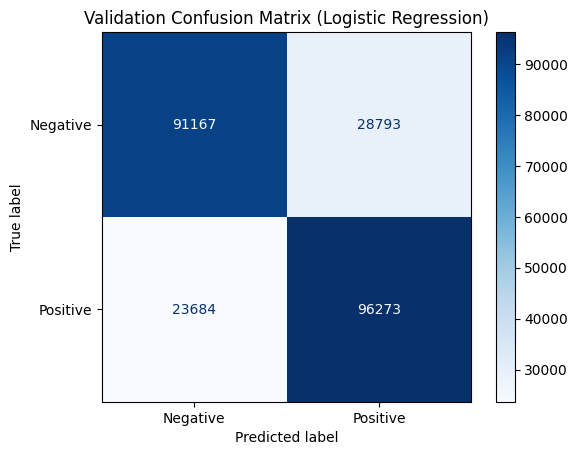

In [11]:
# Next, we view the confusion matrix

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"]).plot(cmap="Blues")
plt.title("Validation Confusion Matrix (Logistic Regression)")
plt.grid(False)
plt.show()